In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
from matplotlib.patches import Circle, ConnectionPatch
import numpy as np
import time
from collections import deque, defaultdict
import math
from networkx.drawing.nx_agraph import graphviz_layout
from sklearn import manifold
import pandas as pd
import community as community_louvain

# Dataset

In [2]:
Graph = nx.nx_agraph.read_dot('./Dataset/LesMiserables.dot/LesMiserables.dot') #Les Miserables
edge_list =[]
for e in Graph.edges():
    u,v = e
    edge_list.append((u,v))

node_list = []
for i in Graph.nodes():
    node_list.append(i)

for u, v, data in Graph.edges(data=True):
    if 'weight' in data:
        data['weight'] = float(data['weight'])
    
print(len(edge_list))
print(len(node_list))

254
77


In [36]:
# def distances_matrix(G):
#     N = len(G.nodes)
#     D = np.ones((N, N)) * np.inf  

#     for i, node_i in enumerate(G.nodes):
#         for j, node_j in enumerate(G.nodes):
#             try:
#                 D[i, j] = nx.shortest_path_length(G, node_i, node_j)
#             except nx.NetworkXNoPath:
#                 continue

#     for i in range(N):
#         D[i, i] = 0
        
#     S = 1 / (D + np.eye(N))   # add identity matrix to avoid division by zero

#     return D

# Distance and similarity matrix

In [43]:
def distances_matrix(G):
    return nx.floyd_warshall_numpy(G, weight='weight')

def similarity_matrix(D):
    with np.errstate(divide='ignore'):
        S = 1 / D
        S[np.isinf(S)] = 0
        S[np.eye(*S.shape, dtype=bool)] = 1  # Set diagonal to maximum similarity
    return S
D = distances_matrix(Graph)
S = similarity_matrix(D)
print('The distance matrix is:\n',D)

print('The similarity matrix is:\n',S)

The distance matrix is:
 [[ 0.  1.  9. ...  9.  9. 11.]
 [ 1.  0.  8. ...  8.  8. 10.]
 [ 9.  8.  0. ...  6.  6.  8.]
 ...
 [ 9.  8.  6. ...  0.  5.  5.]
 [ 9.  8.  6. ...  5.  0.  8.]
 [11. 10.  8. ...  5.  8.  0.]]
The similarity matrix is:
 [[1.         1.         0.11111111 ... 0.11111111 0.11111111 0.09090909]
 [1.         1.         0.125      ... 0.125      0.125      0.1       ]
 [0.11111111 0.125      1.         ... 0.16666667 0.16666667 0.125     ]
 ...
 [0.11111111 0.125      0.16666667 ... 1.         0.2        0.2       ]
 [0.11111111 0.125      0.16666667 ... 0.2        1.         0.125     ]
 [0.09090909 0.1        0.125      ... 0.2        0.125      1.        ]]


## community detection by Louvain

In [44]:
partition = community_louvain.best_partition(Graph)

unique_clusters = list(set(partition.values()))
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_clusters))]
cluster_color_map = dict(zip(unique_clusters, colors))
node_colors = [cluster_color_map[partition[node]] for node in Graph.nodes()]

<p><b>Multidimensional Scaling (MDS):</b> MDS is a technique used for analyzing similarity or dissimilarity data. It attempts to model similarity or dissimilarity data as distances in a geometric spaces. The data can be ratings of similarity between objects, interaction frequencies of molecules, or trade indices between countries.</p>

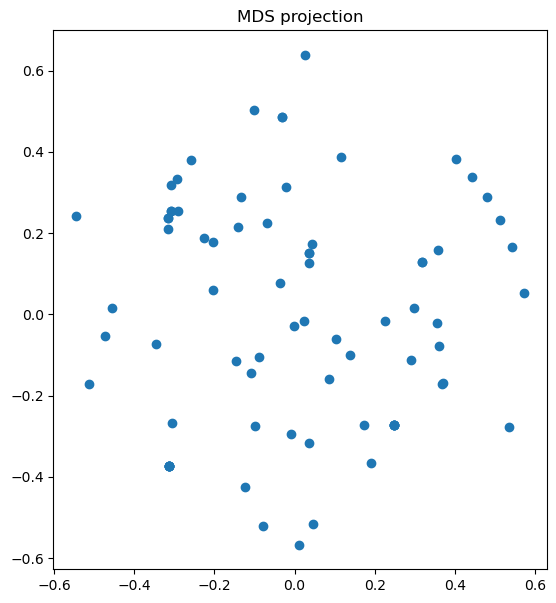

In [45]:
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
pos_mds = mds.fit_transform(1 - S)  # dissimilarity

plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.title('MDS projection')
plt.scatter(pos_mds[:, 0], pos_mds[:, 1], cmap=plt.cm.Spectral)

C:\Users\masou\anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


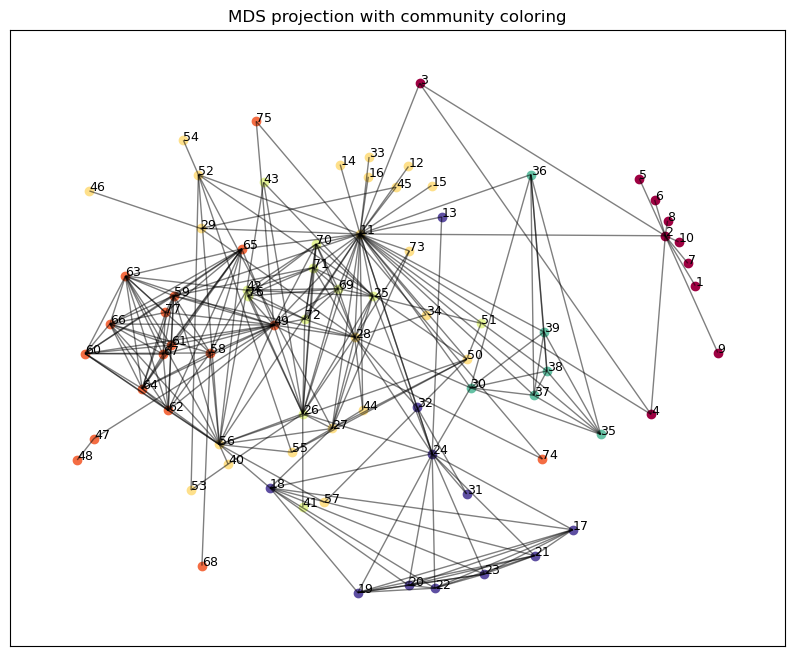

In [45]:
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
pos_mds = mds.fit_transform(1 - S)  # dissimilarity
pos_mds_dict = {node: pos for node, pos in zip(Graph.nodes(), pos_mds)}

plt.figure(figsize=(10, 8))
plt.title('MDS projection with community coloring')
for i, (x, y) in enumerate(pos_mds):
    plt.scatter(x, y, color=node_colors[i], label=partition[node_list[i]])
    plt.text(x, y, node_list[i], fontsize=9)  
nx.draw_networkx_edges(Graph, pos_mds_dict, alpha=0.5)
plt.show()

<p><b>t-Distributed Stochastic Neighbor Embedding (t-SNE):</b> t-SNE is a machine learning algorithm for visualization developed by Laurens van der Maaten and Geoffrey Hinton. It is a nonlinear dimensionality reduction technique that is particularly well-suited for embedding high-dimensional data into a space of two or three dimensions, which can then be visualized in a scatter plot.  The technique can be broken down into two main components:<br>
 <ul>
     <li><b>Stochastic Neighbor Embedding (SNE):</b> SNE starts by converting the high-dimensional Euclidean distances between data points into conditional probabilities that represent similarities. The similarity of datapoint \\(x_j\\) to datapoint \\(x_i\\) is the conditional probability, \\(p_{j∣i}\\), that \\(x_i\\) would pick \\(x_j\\) as its neighbor if neighbors were picked in proportion to their probability density under a Gaussian centered at \\(x_i\\).</li>
     <li><b>t-Distribution:</b> The t-Distribution is used to compute the similarity of two points in the low-dimensional space. The use of the t-Distribution alleviates both the crowding problem and the optimization problem of SNE.</li>
 </ul>
 The t-SNE algorithm iteratively minimizes the divergence between the distributions \\(p_{j∣i}\\) in the high-dimensional space and the distributions \\(q_{j∣i}\\) in the low-dimensional space to find the best low-dimensional representation of the data.<br>
The main advantage of t-SNE is its ability to preserve local structure, meaning that instances that are close in the original space are likely to be close in the embedded space. This makes t-SNE particularly good at creating a single map that reveals structure at many different scales, which is particularly useful for visualizing complex real-world data.<br>
While t-SNE excels at creating intuitive visualizations, the axes of a t-SNE plot don’t have any interpretable meaning. In other words, it’s not generally possible to say what a movement along the x or y axis in the plot corresponds to in the original high-dimensional data space.
</p>

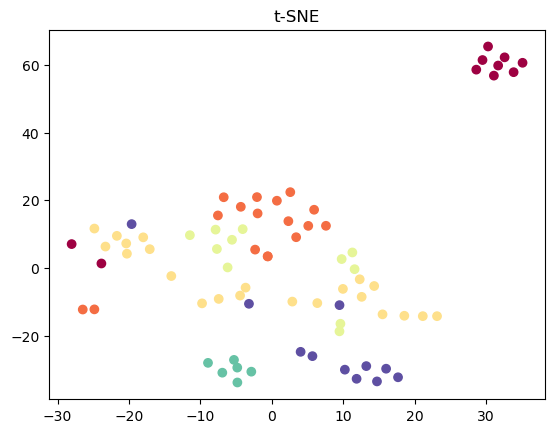

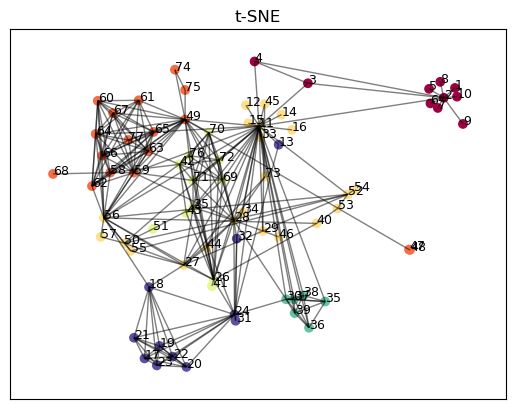

In [70]:
tsne = manifold.TSNE(n_components=2, perplexity=5, random_state=0, metric='precomputed', init='random')
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(1-S)

plt.scatter(Y[:, 0], Y[:, 1], marker = 'o', c=node_colors)

plt.title('t-SNE')
plt.show()

tsne = manifold.TSNE(n_components=2, perplexity=30, random_state=0, metric='precomputed', init='random')
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(1-S)
pos_tsne_dict = {node: pos for node, pos in zip(Graph.nodes(), Y)}
plt.scatter(Y[:, 0], Y[:, 1], marker='o', c=node_colors)  # Use the node colors here

plt.title('t-SNE')
for i, label in enumerate(Graph.nodes()):
    plt.text(Y[i, 0], Y[i, 1], label, fontsize=9)
nx.draw_networkx_edges(Graph, pos_tsne_dict, alpha=0.5)
plt.show()

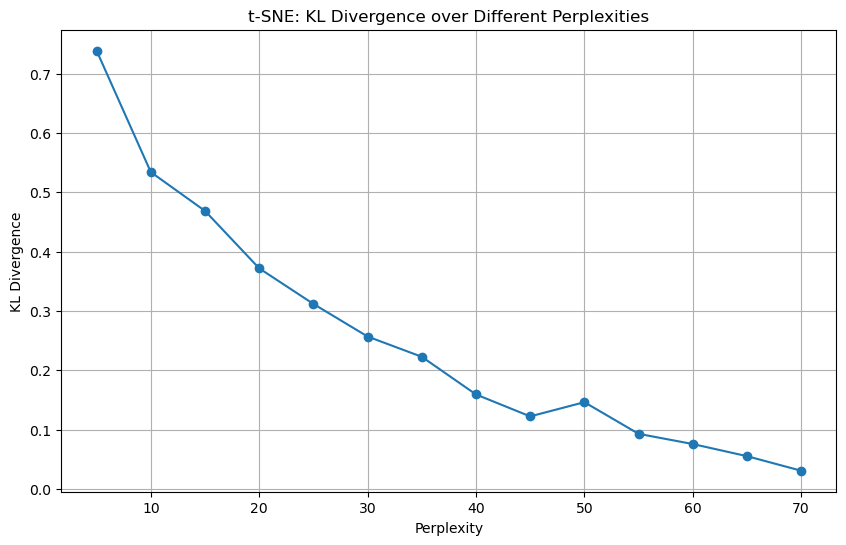

In [64]:
dissimilarity_matrix = 1 - S  
perplexities = np.arange(5, 71, 5)  
kl_divergences = []

for perp in perplexities:
    tsne = manifold.TSNE(n_components=2, perplexity=perp, random_state=0, metric='precomputed', init='random')
    _ = tsne.fit_transform(dissimilarity_matrix)
    kl_divergences.append(tsne.kl_divergence_)

plt.figure(figsize=(10, 6))
plt.plot(perplexities, kl_divergences, marker='o')
plt.title('t-SNE: KL Divergence over Different Perplexities')
plt.xlabel('Perplexity')
plt.ylabel('KL Divergence')
plt.grid(True)
plt.show()

<p><b>Isomap:</b> Isomap is a nonlinear dimensionality reduction method. It is one of several widely used low-dimensional embedding methods. Isomap begins by constructing a neighborhood network. After that, it uses graph distance to approximate the geodesic distance between all pairs of points. Finally, it uses classical multidimensional scaling to construct a d-dimensional Euclidean coordinate system in which the distances between points reflect the geodesic distances between points.</p>

C:\Users\masou\anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\masou\anaconda3\envs\myenv\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


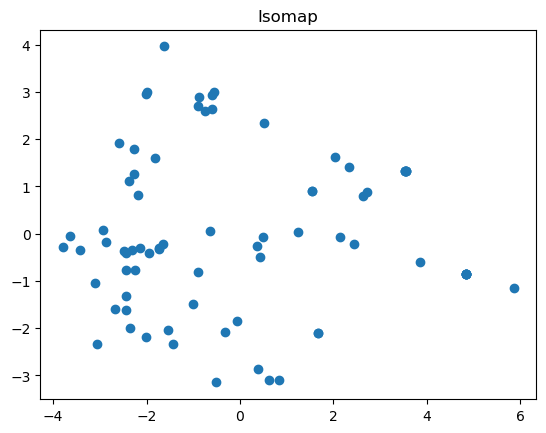

C:\Users\masou\anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\masou\anaconda3\envs\myenv\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


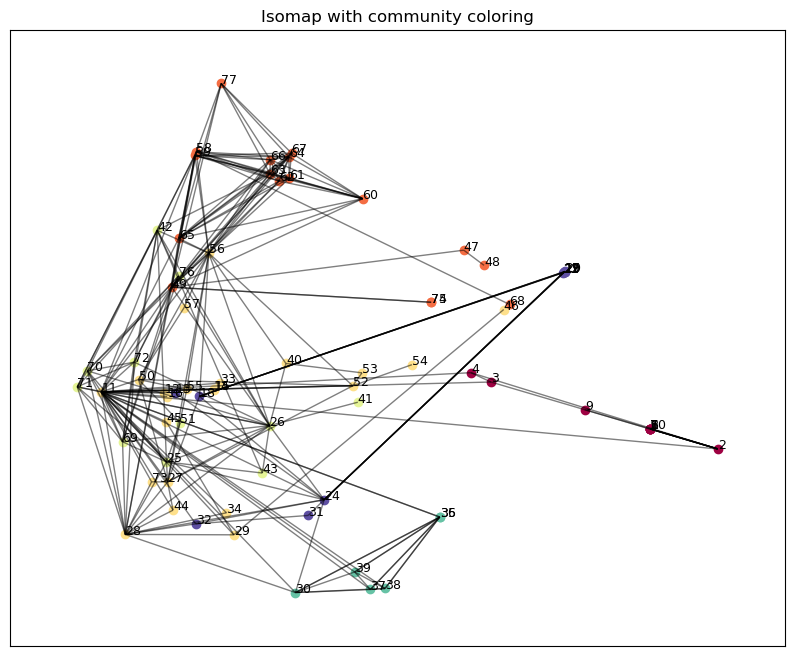

In [73]:
iso = manifold.Isomap(n_neighbors=6, n_components=2)
iso.fit(1-S)
manifold_2Da = iso.transform(1-S)
manifold_2D = pd.DataFrame(manifold_2Da, columns=['Component 1', 'Component 2'])

plt.scatter(manifold_2D['Component 1'], manifold_2D['Component 2'], marker = 'o')
plt.title('Isomap')
plt.show()



iso = manifold.Isomap(n_neighbors=6, n_components=2)
iso.fit(1-S)
manifold_2Da = iso.transform(1-S)
manifold_2D = pd.DataFrame(manifold_2Da, columns=['Component 1', 'Component 2'])
pos_iso_dict = {node: (manifold_2D.loc[i, 'Component 1'], manifold_2D.loc[i, 'Component 2']) for i, node in enumerate(Graph.nodes())}
plt.figure(figsize=(10, 8))
plt.title('Isomap with community coloring')
for i, node in enumerate(Graph.nodes()):
    plt.scatter(manifold_2D.loc[i, 'Component 1'], manifold_2D.loc[i, 'Component 2'], color=node_colors[i])
    plt.text(manifold_2D.loc[i, 'Component 1'], manifold_2D.loc[i, 'Component 2'], node, fontsize=9)  
nx.draw_networkx_edges(Graph, pos_iso_dict, alpha=0.5)
plt.show()


C:\Users\masou\anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\masou\anaconda3\envs\myenv\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\masou\anaconda3\envs\myenv\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\masou\anaconda3\envs\myenv\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row,

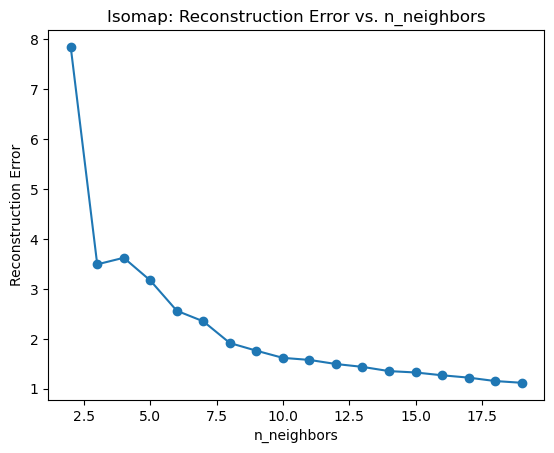

In [71]:
reconstruction_errors = []
n_neighbors_options = range(2, 20)  # Vary this range as needed.

for n_neighbors in n_neighbors_options:
    iso = manifold.Isomap(n_neighbors=n_neighbors, n_components=2)
    iso.fit(1 - S)
    reconstruction_errors.append(iso.reconstruction_error())

# Plot the reconstruction error
plt.plot(n_neighbors_options, reconstruction_errors, marker='o')
plt.xlabel('n_neighbors')
plt.ylabel('Reconstruction Error')
plt.title('Isomap: Reconstruction Error vs. n_neighbors')
plt.show()

# Testing projection methods with another dataset

In [81]:
Graph2 = nx.nx_agraph.read_dot('./Dataset/rome.dot/rome.dot')  # Rome
D2 = distances_matrix(Graph2)
S2 = similarity_matrix(D2)

mds2 = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
pos_mds2 = mds2.fit_transform(1 - S2)  # dissimilarity
pos_mds_dict2 = {node: pos for node, pos in zip(Graph2.nodes(), pos_mds2)}

tsne2 = manifold.TSNE(n_components=2, perplexity=40, random_state=0, metric='precomputed', init='random')
np.set_printoptions(suppress=True)
Y2 = tsne2.fit_transform(1-S2)
pos_tsne_dict2 = {node: pos for node, pos in zip(Graph2.nodes(), Y2)}

iso2 = manifold.Isomap(n_neighbors=6, n_components=2)
iso2.fit(1-S2)
manifold_2D_2a = iso2.transform(1-S2)
manifold_2D_2 = pd.DataFrame(manifold_2D_2a, columns=['Component 1', 'Component 2'])
pos_iso_dict2 = {node: (manifold_2D_2.loc[i, 'Component 1'], manifold_2D_2.loc[i, 'Component 2']) for i, node in enumerate(Graph2.nodes())}

C:\Users\masou\anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


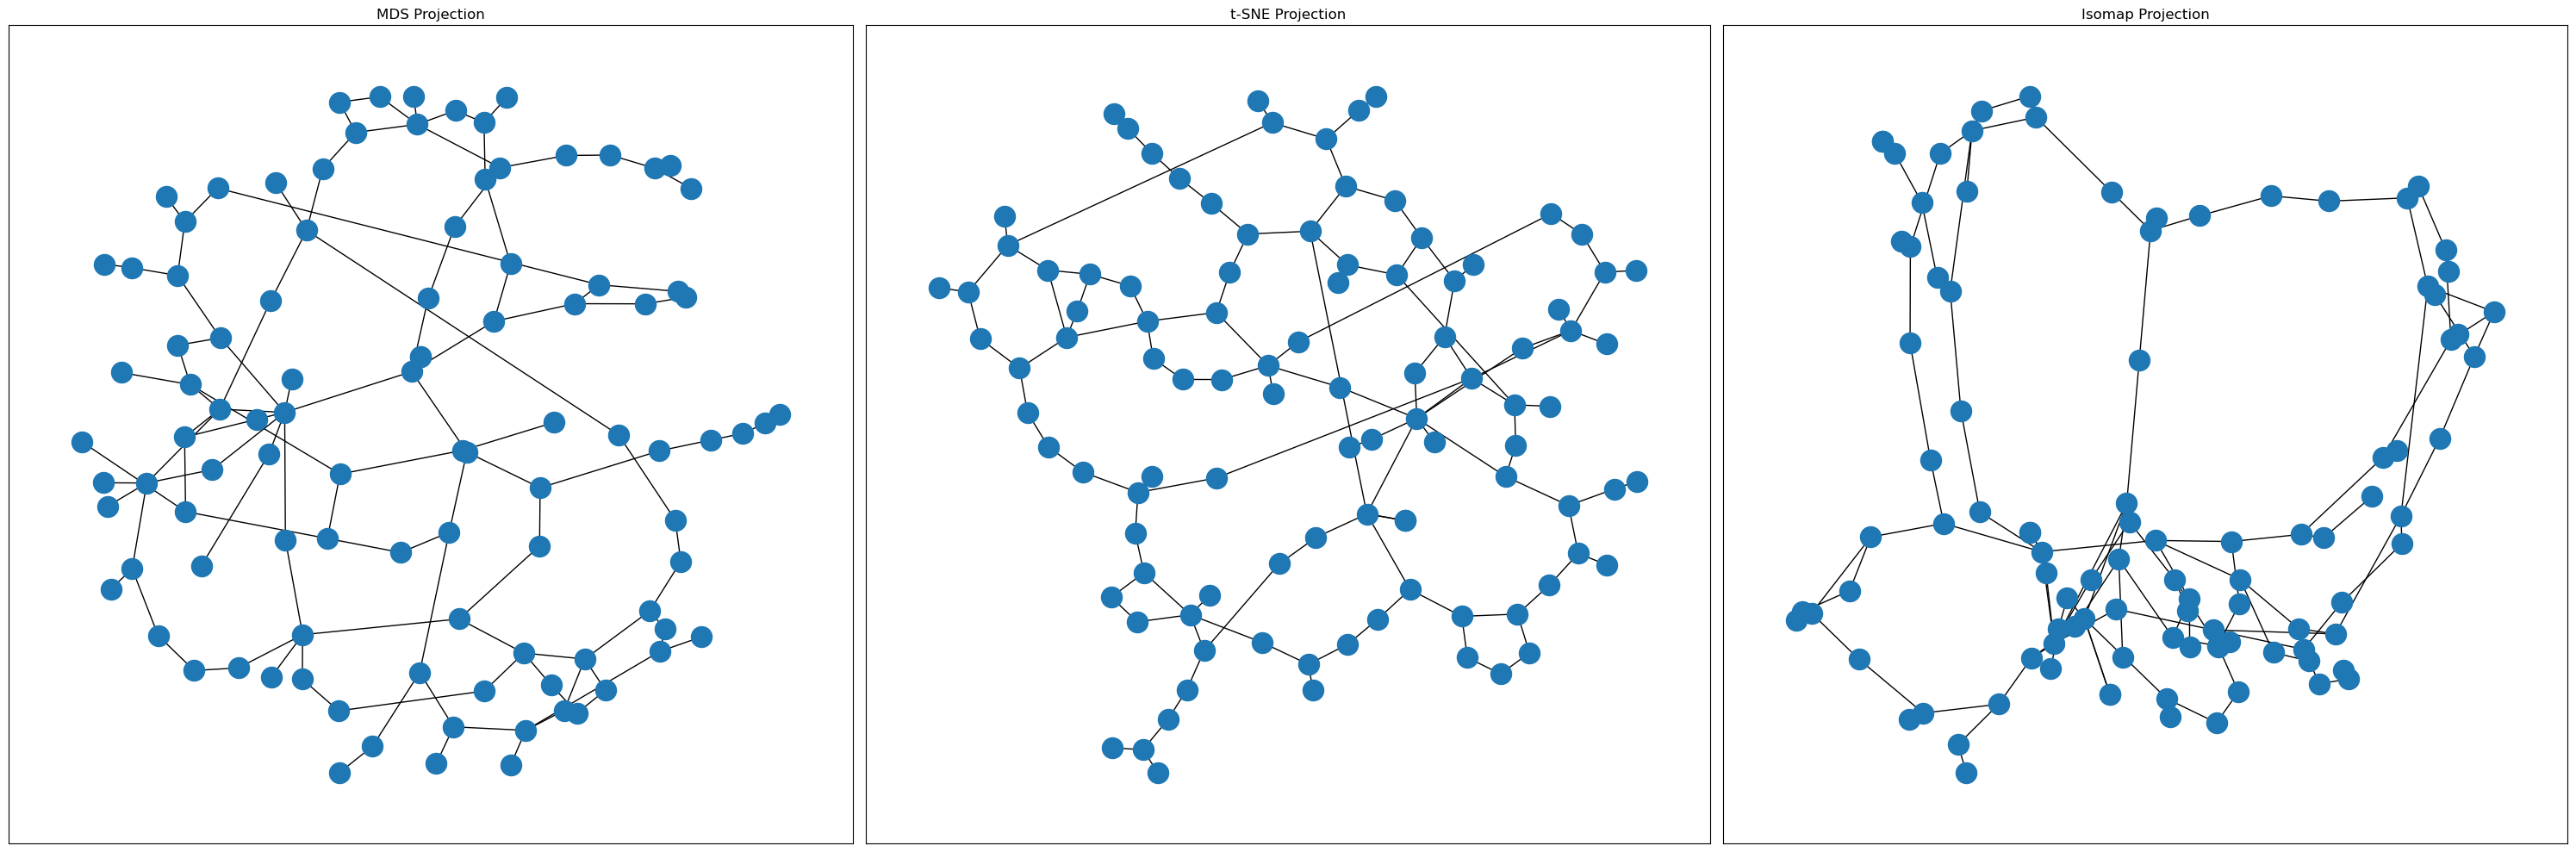

In [82]:
fig, axs = plt.subplots(1, 3, figsize=(30, 10))  # 1 row, 3 columns

# MDS plot
ax = axs[0]
nx.draw_networkx_nodes(Graph2, pos=pos_mds_dict2, ax=ax)
nx.draw_networkx_edges(Graph2, pos=pos_mds_dict2, ax=ax)
ax.set_title("MDS Projection")

# t-SNE plot
ax = axs[1]
nx.draw_networkx_nodes(Graph2, pos=pos_tsne_dict2, ax=ax)
nx.draw_networkx_edges(Graph2, pos=pos_tsne_dict2, ax=ax)
ax.set_title("t-SNE Projection")

# Isomap plot
ax = axs[2]
nx.draw_networkx_nodes(Graph2, pos=pos_iso_dict2, ax=ax)
nx.draw_networkx_edges(Graph2, pos=pos_iso_dict2, ax=ax)
ax.set_title("Isomap Projection")

plt.tight_layout()
plt.show()